# Import

In [203]:
from collections import Counter

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
from pymorphy2 import MorphAnalyzer
import nltk
from nltk import ngrams
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data analytics

## Load data

In [352]:
df = pd.read_csv("/home/jupyter/mnt/s3/generalvibe/data/clean_train.csv", index_col=0).reset_index()
df.sample(5)

,sentence,1category,sentiment,length
5704,Спасибо сотруднику контактного центра Катерине...,Communication,+,186
5313,"Неделю назад обслуживал, а сейчас отказывается!",Quality,−,47
3419,"Это издевательство, сколько можно что-то приду...",Quality,−,53
5603,Спасибо Росбанку за таких сотрудников!)),Communication,+,40
3571,Приятно сотрудничать с профессионалами.,Quality,+,39


## Basic visualisations

Набор данных не сбалансирован 

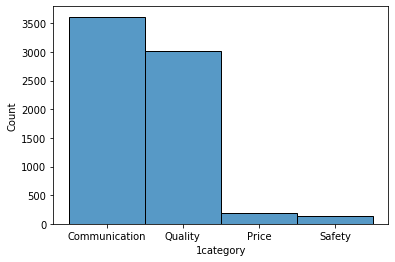

In [435]:
sns.histplot(data=df, x='1category')
None

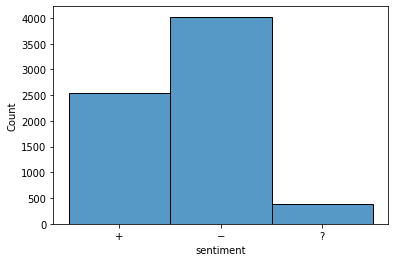

In [436]:
sns.histplot(data=df, x='sentiment')
None

В наборе данных присутствуют заметные различия тональности по категориям

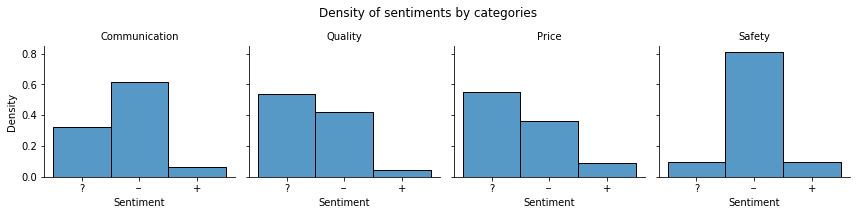

In [423]:
grid = sns.FacetGrid(data=df, col='1category')
grid.map(sns.histplot, 'sentiment', stat='density')
grid.set_titles("{col_name}")
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle('Density of sentiments by categories', size=12)
grid.set_axis_labels(x_var="Sentiment", y_var="Density")
plt.show()

## Feature engineering

Создадим новые признаки:
1. Длина отзыва
2. Наличие специальных символов
3. Наличие текста написанного заглавными буквами
4. Наличие цифр в отзыве

Выясним, насколько они информативны

In [382]:
df['sentence length'] = [len(text) for text in df['sentence']]
df['have spec char'] = df['sentence'].apply(lambda s: 'True' if any(i for i in s if i in ['?', '!', '@', '#', '*']) else 'False')
df['caps'] = df['sentence'].apply(lambda s: 'True' if sum([1 for c in s if c.isupper()]) / len(s) > 0.1 else 'False')
df['have number'] = df['sentence'].apply(lambda s: 'True' if bool(re.search(r'\d', s)) else 'False')

In [358]:
df.sample(5)

,sentence,1category,sentiment,length,sentence length,have spec char,caps,have number
3758,"Я являюсь постоянным клиентом Почта Банка, пр...",Communication,+,569,569,False,False,True
2112,"Арина все очень подробно и понятно объяснила, ...",Communication,+,86,86,False,False,False
3215,"Ладно вышел на улице, позвонил, объяснил ситуа...",Communication,?,308,308,False,False,True
1219,"Либо вообще лишить должности, такие агрессивны...",Communication,−,92,92,False,False,False
2576,"На сообщение в чате не отвечают, по телефону о...",Communication,−,85,85,False,False,False


### Sentence length

Видно, что медиана отрицательных отзывов больше, чем у положительных 

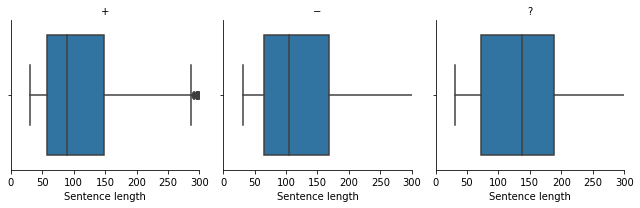

In [427]:
grid = sns.FacetGrid(data=df, col='sentiment', xlim=(0, 300))
grid.map(sns.boxplot, 'sentence length', order=['+', '?', '−'])
grid.set_titles("{col_name}")
grid.set_axis_labels(x_var="Sentence length",)
plt.show()

In [363]:
grouped_medians = df.groupby(['1category', 'sentiment'])['sentence length'].median().reset_index()
grouped_medians

,1category,sentiment,sentence length
0,Communication,+,93.0
1,Communication,?,139.0
2,Communication,−,105.0
3,Price,+,102.5
4,Price,?,131.0
5,Price,−,107.5
6,Quality,+,87.0
7,Quality,?,134.0
8,Quality,−,104.0
9,Safety,+,116.0


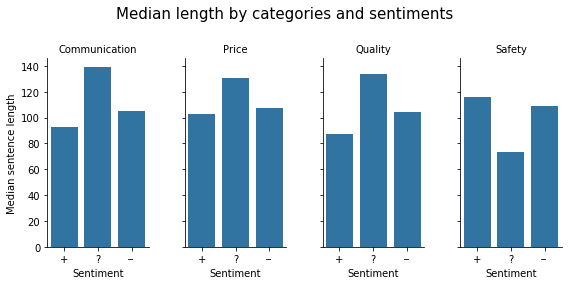

In [376]:
g = sns.FacetGrid(grouped_medians, col="1category", height=4, aspect=.5)
g.map(sns.barplot, "sentiment", "sentence length", order=['+', '?', '−'], )
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Median length by categories and sentiments', size=15)
g.set_axis_labels(x_var="Sentiment", y_var="Median sentence length")
None

### Special characters

Наличие специальных симовлов (!?@#) чаще встречается в негативных отзывах

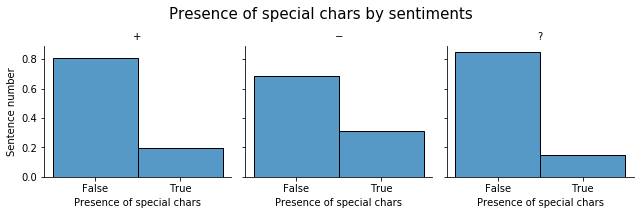

In [383]:
grid = sns.FacetGrid(data=df, col='sentiment')
grid.map(sns.histplot, 'have spec char', discrete=True, stat='density')
grid.set(ylabel = "Sentence number", xlabel="Presence of !?", )
grid.set_titles("{col_name}")
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle('Presence of special chars by sentiments', size=15)
grid.set_axis_labels(x_var="Presence of special chars", y_var="Sentence number")
plt.show()

### CAPS

Рассмотрим отзывы, написанные заглавными буквами. Видно, что большинство таких отзывов негативные.

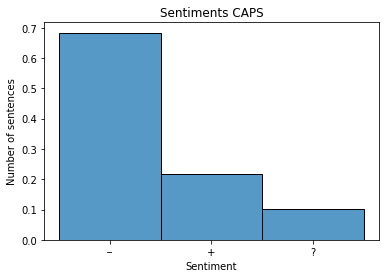

In [420]:
h = sns.histplot(data=df[df['caps'] == 'True'], x='sentiment', stat='density')
h.set_title('Sentiments CAPS')
h.set_xlabel('Sentiment')
h.set_ylabel('Number of sentences')
plt.show()

### Digits in text

Наличие цифр встречается в негативных отзывах немного чаще, чем в остальных

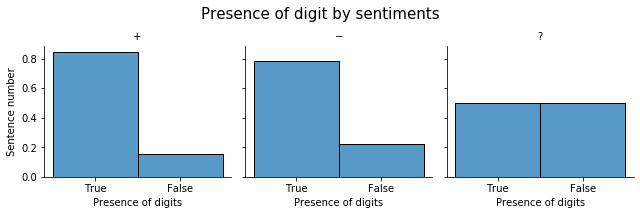

In [389]:
grid = sns.FacetGrid(data=df, col='sentiment')
grid.map(sns.histplot, 'have number', discrete=True, stat='density')
grid.set(ylabel = "Sentence number", xlabel="Presence of !?", )
grid.set_titles("{col_name}")  # use this argument literally
grid.fig.subplots_adjust(top=0.8)
grid.fig.suptitle('Presence of digit by sentiments', size=15)
grid.set_axis_labels(x_var="Presence of digits", y_var="Sentence number")
plt.show()

# Ngrams 

In [125]:
morph = MorphAnalyzer()

my_stopwords = [*stopwords.words('russian'), 'это']

def lemmatize(word: str):
    lemma = morph.parse(word)[0].normal_form
    return lemma

def get_ngrams(text: str, n: int, top: int):
    words = [w for w in full_text.split() if w not in my_stopwords]
    words = [lemmatize(w) for w in words]
    x = ngrams(words, n)
    x = Counter(x).most_common(top)
    x = [(' '.join(words), value) for words, value in x]
    labels = [label for label, _ in x]
    values = [value for _, value in x]
    return labels, values

categories = df['1category'].unique()
sentiments = df['sentiment'].unique()
my_stopwords = [*stopwords.words('russian'), 'это', 'сей', 'пора']

## Bigrams 

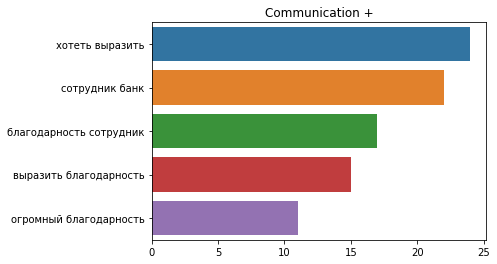

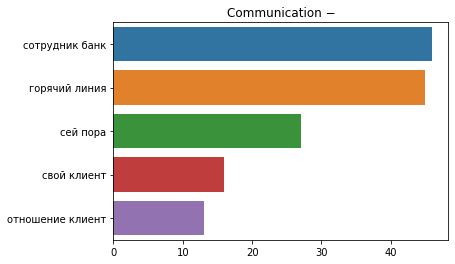

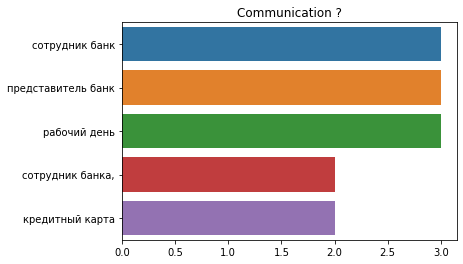

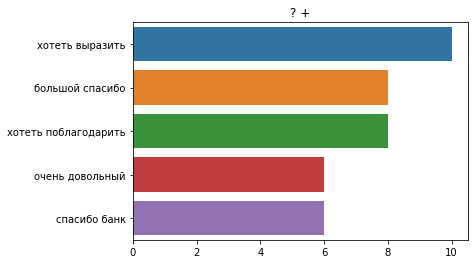

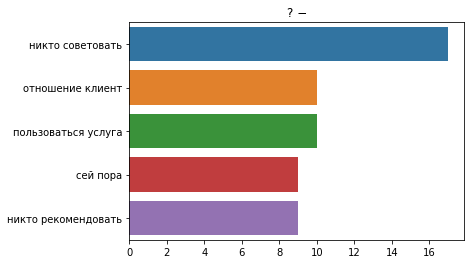

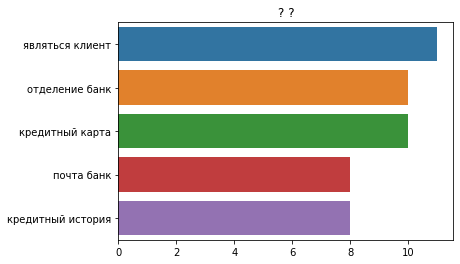

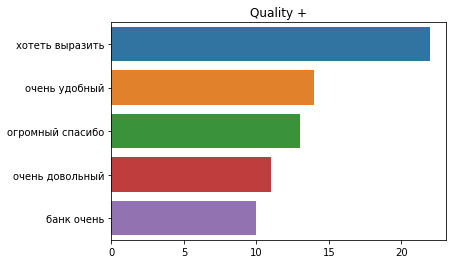

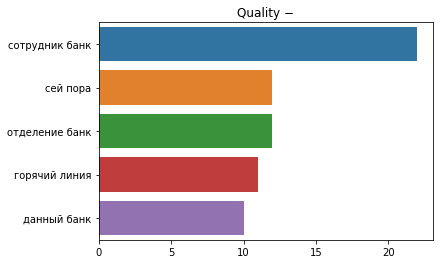

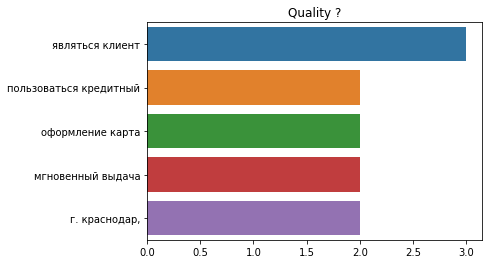

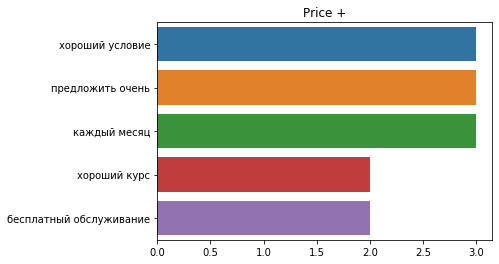

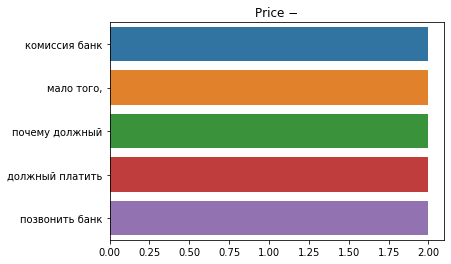

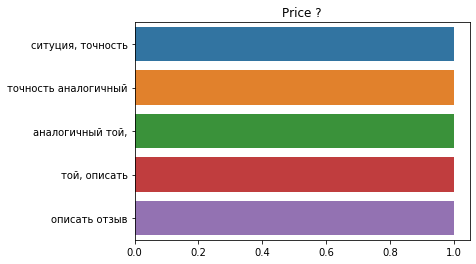

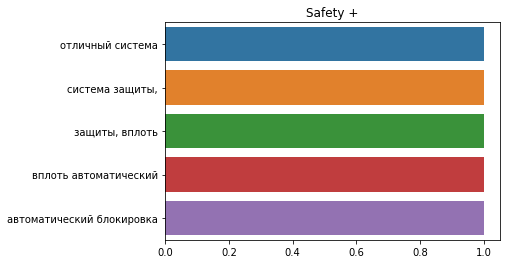

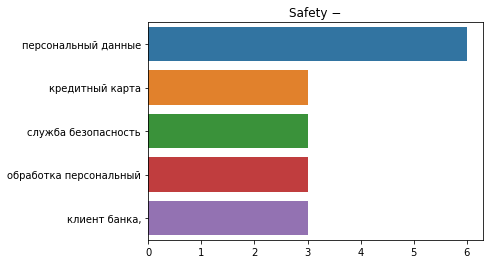

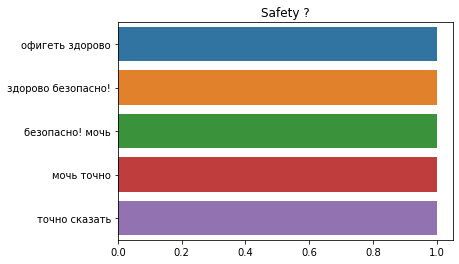

In [126]:
for c in categories:
    for s in sentiments:
        subset = df[(df['1category'] == c) & (df['sentiment'] == s)]
        full_text = ' '.join(subset['sentence'].values).lower()
        labels, values = get_ngrams(full_text, 2, 5)
        sns.barplot(x=values, y=labels).set_title(f"{' '.join([c, s])}")
        plt.show()

## Trigrams

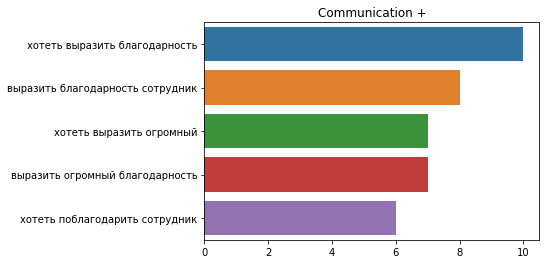

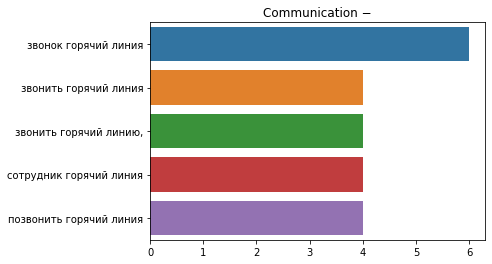

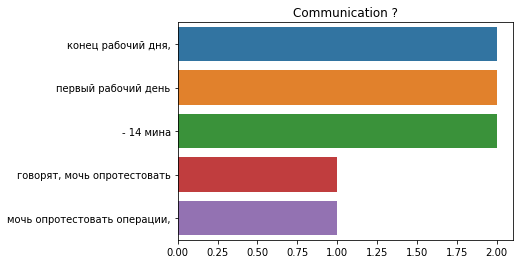

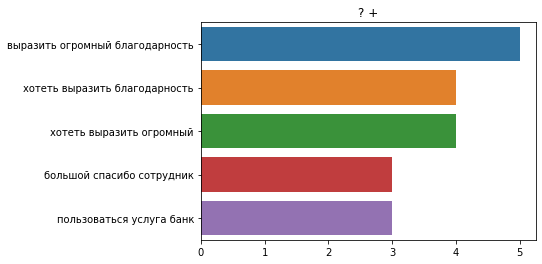

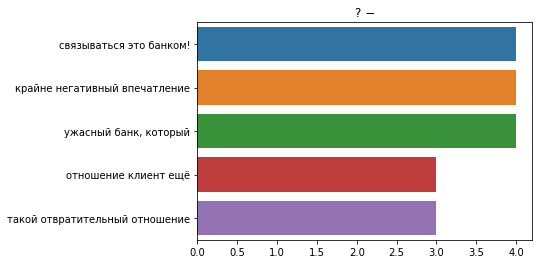

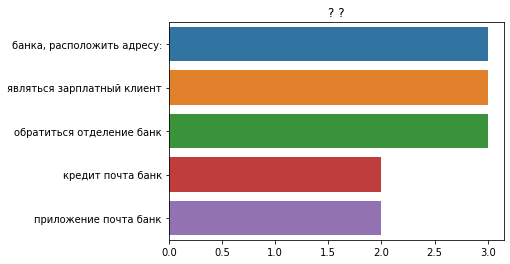

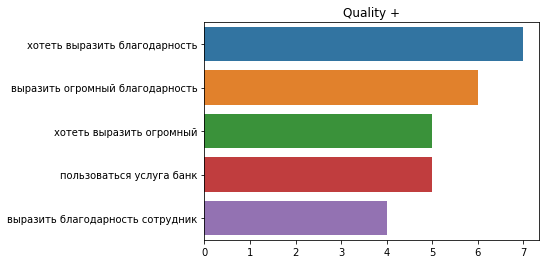

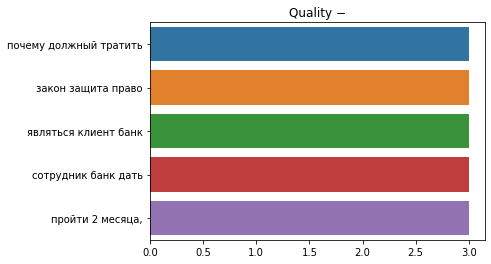

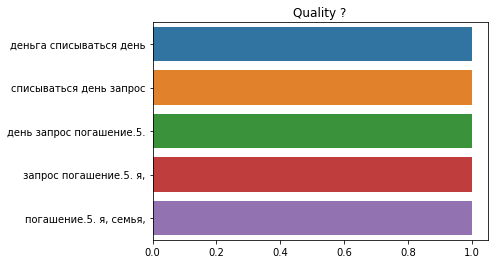

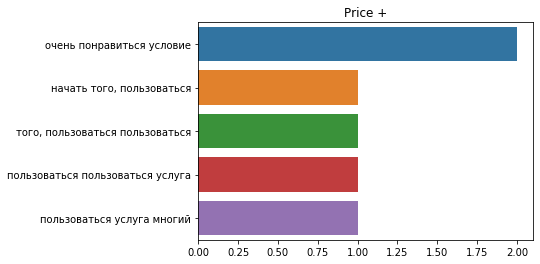

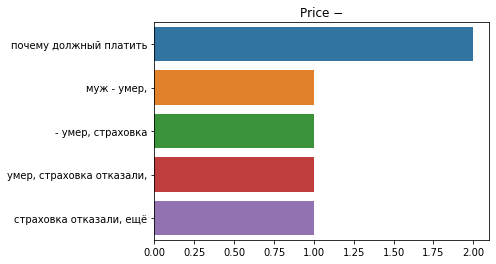

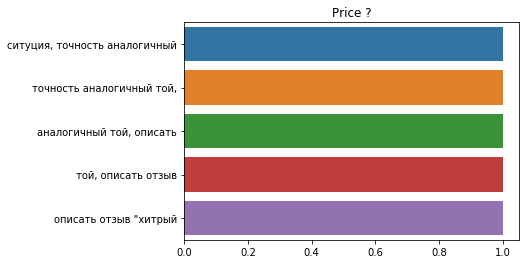

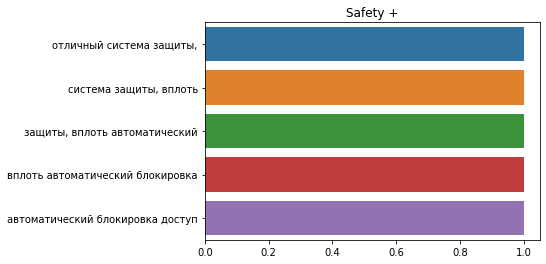

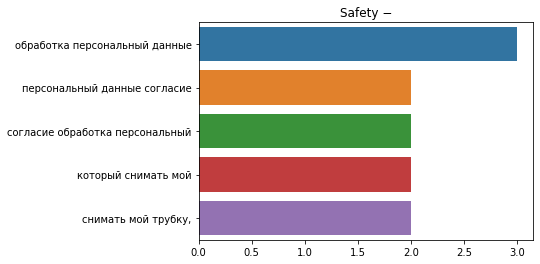

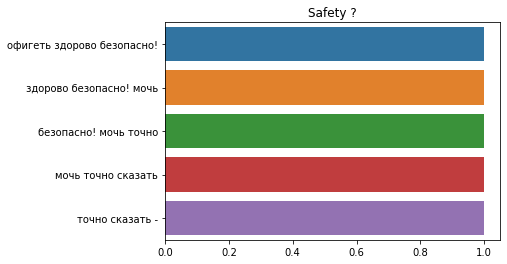

In [127]:
for c in categories:
    for s in sentiments:
        subset = df[(df['1category'] == c) & (df['sentiment'] == s)]
        full_text = ' '.join(subset['sentence'].values).lower()
        labels, values = get_ngrams(full_text, 3, 5)
        sns.barplot(x=values, y=labels).set_title(f"{' '.join([c, s])}")
        plt.show()